In [18]:
# import modules
import numpy as np
from astropy.io import fits
import pandas as pd
from RotationCurveTiltedRings import FitTiltedRings
import numpy as np
from astropy import wcs
from astropy.io import fits
from matplotlib import pyplot as plt

from astropy.table import Table
from astropy import units as u
import time

import os
import sys

from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn,unique,vstack
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator
from matplotlib import colors
from matplotlib.colors import LogNorm
from linetools.spectra.xspectrum1d import XSpectrum1D
import model_NaI
#import model_fitter
import continuum_normalize_NaI
#import NaImcmc_read_fits
#import NaImcmc_fitwrapper
#import ew_NaI_allspax
import pdb
import corner 
import glob
import os

import emcee
import numpy.ma as ma
from kcwi_jnb import cube
from kcwi_jnb import transform
from HIIdentify import HIIdentify
from HIIdentify import HIIdentify_plots

plt.rcParams['figure.figsize'] = (8,8)
plt.rc('axes', labelsize = 25)
plt.rc('axes', titlesize = 18)
#plt.rc('axes', titleweight = 'bold')
plt.rc('axes', lw = 2)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

In [19]:
# MUSE cube directory for 2.0 binning
main_dir = '/Users/erickaguirre/mangadap/examples/'
main_dir2 = '/Users/erickaguirre/Desktop/SDSU_Research/Getting_used_to_MaNGA_DAP/'
main_dir3 = '/Users/erickaguirre/Desktop/DAP_outputs/'

# NGC 4030
NGC4030_output_dir = 'output0.6_NGC4030_NOISM_err_corr/'
NGC4030_cube_dir = 'SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/'
# log cube
NGC4030_cube0_6_file = main_dir3+ NGC4030_output_dir+ NGC4030_cube_dir+\
                       'manga-1-1-LOGCUBE-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits'
NGC4030_cube0_6 = fits.open(NGC4030_cube0_6_file)

# log maps
NGC4030_map_file = main_dir3+ NGC4030_output_dir+ NGC4030_cube_dir+\
                   'manga-1-1-MAPS-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits'
NGC4030_map = fits.open(NGC4030_map_file)

# For continuum-normalization around NaI
# wavelength continuum fitting range outside of NaI region
blim = [5850.0,5870.0]
rlim = [5910.0,5930.0]
# wavelength fitting range inside of NaI region
fitlim = [5880.0,5910.0]
# speed of light in km/s
c = 2.998e5
# Na I doublet vacuum absorption wavelengths 
D2 = 5891.582 # in angstroms
D1 = 5897.558 # in angstroms

# redshift 
z = 0.00489
# obtain flux array from MUSE cube
flux = NGC4030_cube0_6['FLUX'].data
model = NGC4030_cube0_6['MODEL'].data
ivar = NGC4030_cube0_6['IVAR'].data
error = np.sqrt(1/ivar)
wave = NGC4030_cube0_6['WAVE'].data

# obtain stellar velocity, stellar dispersion and bin id data from the galaxy
stellar_vel =  NGC4030_map['STELLAR_VEL'].data
stellar_sigma = NGC4030_map['STELLAR_SIGMA'].data
binid_map = NGC4030_map['BINID'].data[0]

# Need LSF in km/s
# This gives LSF in Ang
# CAUTION: this does not convert air wavelengths
# to vacuum, or account for velocity offset of each bin
redshift = 0.00489 
LSFdir = '/Users/erickaguirre/Desktop/SDSU_Research/Getting_used_to_MaNGA_DAP/'
LSFfil = LSFdir + 'LSF-Config_MUSE_WFM'
configLSF = np.genfromtxt(LSFfil, comments='#')
configLSF_wv_air = configLSF[:,0]
configLSF_res = configLSF[:,1]

# convert to vacuum since LSF is in air
xspec = XSpectrum1D.from_tuple((configLSF_wv_air, 0.0*configLSF_wv_air))
xspec.meta['airvac'] = 'air'
xspec.airtovac()
configLSF_wv_vac = xspec.wavelength.value

configLSF_restwv = configLSF_wv_vac / (1.0+redshift)
whLSF = np.where((configLSF_restwv > fitlim[0]) & (configLSF_restwv < fitlim[1]))

median_LSFAng = np.median(configLSF_res[whLSF[0]])
median_LSFvel = c * median_LSFAng / np.median(configLSF_wv_vac[whLSF[0]])
LSFvel = median_LSFvel

/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_7653/3457387990.py:37: RuntimeWarning: divide by zero encountered in true_divide
  error = np.sqrt(1/ivar)
/Users/erickaguirre/packages/linetools/linetools/spectra/xspectrum1d.py:107: UserWarning: Assuming wavelength unit is Angstroms
  warnings.warn("Assuming wavelength unit is Angstroms")


In [20]:
# emission line header dictionary
emline = {}
for k, v in NGC4030_map['EMLINE_GFLUX'].header.items():
    if k[0] == 'C':
        try:
            i = int(k[1:])-1
        except ValueError:
            continue
        emline[v] = i
        
# H-alpha emission line flux from MUSE cube (1E-17 erg/s/cm^2/spaxel)
# 23rd index = 24 channel
halpha_map = NGC4030_map['EMLINE_GFLUX'].data[emline['Ha-6564'],:,:]
halpha_err_map = np.sqrt(1/NGC4030_map['EMLINE_GFLUX_IVAR'].data[emline['Ha-6564'],:,:])
# H-beta emission line flux from MUSE cube
hbeta_map = NGC4030_map['EMLINE_GFLUX'].data[emline['Hb-4862'],:,:]
hbeta_err_map = np.sqrt(1/NGC4030_map['EMLINE_GFLUX_IVAR'].data[emline['Hb-4862'],:,:])

# Emission line EW and error
# H-alpha 
halpha_EW_map = NGC4030_map['EMLINE_GEW'].data[emline['Ha-6564'],:,:]
halpha_EW_err_map = np.sqrt(1/NGC4030_map['EMLINE_GEW_IVAR'].data[emline['Ha-6564'],:,:])
# H-beta 
hbeta_EW_map = NGC4030_map['EMLINE_GEW'].data[emline['Hb-4862'],:,:]
hbeta_EW_err_map = np.sqrt(1/NGC4030_map['EMLINE_GEW_IVAR'].data[emline['Hb-4862'],:,:])

# H-alpha velocity map from MUSE cube (km/s)
halpha_vel_map = NGC4030_map['EMLINE_GVEL'].data[emline['Ha-6564'],:,:]
    
# #     if method == 'ccm':
# #     halpha and hbeta emissionlines sdss website 
# #     https://classic.sdss.org/dr7/products/spectra/vacwavelength.html
# # k_lambda_halpha = extinction.ccm89(np.array([6564.614]),a_v = 4.05, r_v = 3.1, unit='aa')
# # k_lambda_hbeta = extinction.ccm89(np.array([4862.721]),a_v = 4.05, r_v = 3.1, unit='aa')
# #     elif method == 'odonnell':
# # k_lambda_halpha = extinction.calzetti00(np.array([6564.614]),a_v = 4.05, r_v = 3.1, unit='aa')
# # k_lambda_hbeta = extinction.calzetti00(np.array([4862.721]),a_v = 4.05, r_v = 3.1, unit='aa')
# method = 'calzetti'
# if method == 'calzetti':
#     # extinction in magnitudes using Calzettie et al. 2000 extinction curve
#     k_lambda_halpha = extinction.calzetti00(np.array([6564.614]),a_v = 4.05, r_v = 3.1, unit='aa')
#     k_lambda_hbeta = extinction.calzetti00(np.array([4862.721]),a_v = 4.05, r_v = 3.1, unit='aa')
# #     elif method == 'fitzpatrick':
# #         k_lambda_halpha = extinction.fitzpatrick99(np.array([6564.614]),a_v = 4.05, r_v = 3.1, unit='aa')
# #         k_lambda_hbeta = extinction.fitzpatrick99(np.array([4862.721]),a_v = 4.05, r_v = 3.1, unit='aa')
# #     elif method == 'fitzpatrick_massa':
# #         # assuming r_v = 3.1
# #         k_lambda_halpha = extinction.fm07(np.array([6564.614]),a_v = 4.05, unit='aa')
# #         k_lambda_hbeta = extinction.fm07(np.array([4862.721]),a_v = 4.05, unit='aa')

#     #dust attenuation map
# # if method2 == 'method1':
# ebv_map = 0.935 * np.log( (halpha_map/hbeta_map) /2.86 )
# # elif method2 == 'method2':
# # ebv_map = (1.086/(k_lambda_hbeta - k_lambda_halpha) ) * np.log( (halpha_map/hbeta_map) /2.86 )
# # ebv_map = (2.5 /(k_lambda_hbeta - k_lambda_halpha) ) * np.log10( (halpha_map/hbeta_map) /2.86 )
# # any E(B-V) value less than 0 is unrealistic, and must be changed to 0
# ebv_map[ebv_map < 0] = 0.
#     # corrected h-alpha map 
# # halpha_map_corrected = halpha_map * (10**(0.4*k_lambda_halpha*ebv_map))
# halpha_map_corrected = halpha_map * (10**(0.4*k_lambda_halpha*ebv_map))
# # replace NaN values w/ finite values
# ebv_map[np.logical_not(np.isfinite(ebv_map))] = -999
# # use good values in original h-alpha map to replace NaN values
# # in corrected h-alpha map due to nan values from ebv map
# nan_indx = np.where(np.isfinite(halpha_map_corrected) == False)
# halpha_map_corrected[nan_indx] = halpha_map[nan_indx]

# # recessional velocity of NGC 4030 (SIMBAD value) (km/s)
# v_recess = 1467.2 * (u.kilometer / u.second)
# # Hubble constant (km/s/Mpc)
# H_0 = 70 * (u.kilometer / (u.second * 1e6 * u.parsec) )
# # NGC4030 distance
# #r = (v_recess / H_0).to(u.centimeter)
# r = (29.99 * 1e6 * u.parsec).to(u.centimeter)
# # h-alpha luminosity map (ergs/s)
# L_halpha = 4*np.pi * r**2 * halpha_map_corrected * ( (1e-17 * u.erg) / (u.second * u.centimeter**2) )
# # SFR map from h-alpha luminosity in units of M_sun / year
# #SFR_map = 7.94*10**(-42) * L_halpha * (u.second / u.erg) * (u.Msun / u.year)
# SFR_map = 10**(-41.27) * L_halpha * (u.second / u.erg) * (u.Msun / u.year)
#     #return np.sum( SFR_map.flatten() )

# logSFR_map = np.log10(L_halpha.value) - 41.27
# logSFR_map[np.logical_not(np.isfinite(logSFR_map))] = -999
# halpha_map_corrected[np.logical_not(np.isfinite(halpha_map_corrected))] = -999

# # SNR per spaxel and bin ID
# snr_spxl_map = NGC4030_map['SPX_SNR'].data
# snr_bin_map = NGC4030_map['BIN_SNR'].data
# obtain image data averaged around Na I region from MUSE cube
dc = cube.DataCube(inp=NGC4030_cube0_6_file)
n_band = transform.narrowband(dc, 5880, 5910, mode='median')
img_data = n_band.data

/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_7653/1573130781.py:14: RuntimeWarning: divide by zero encountered in true_divide
  halpha_err_map = np.sqrt(1/NGC4030_map['EMLINE_GFLUX_IVAR'].data[emline['Ha-6564'],:,:])
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_7653/1573130781.py:17: RuntimeWarning: divide by zero encountered in true_divide
  hbeta_err_map = np.sqrt(1/NGC4030_map['EMLINE_GFLUX_IVAR'].data[emline['Hb-4862'],:,:])
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_7653/1573130781.py:22: RuntimeWarning: divide by zero encountered in true_divide
  halpha_EW_err_map = np.sqrt(1/NGC4030_map['EMLINE_GEW_IVAR'].data[emline['Ha-6564'],:,:])
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_7653/1573130781.py:25: RuntimeWarning: divide by zero encountered in true_divide
  hbeta_EW_err_map = np.sqrt(1/NGC4030_map['EMLINE_GEW_IVAR'].data[emline['Hb-4862'],:,:])


In [21]:
# load the data
file = fits.open('NGC4030_0.6_err_corr_mcmc_output.fits')
table_all = Table(file[1].data)
gas_vel_map = file[2].data

# filter out bad values
table_good = table_all[table_all['velocities'] > -999]
# exclude velocities with high confidence interval widths
vel_widths = np.absolute(table_good['vel_uncert_84th_percent']-table_good['vel_uncert_16th_percent'])

vel_width_map = np.zeros(gas_vel_map.shape)
for binid in table_good['bin']:
    index = np.where(binid_map == binid)
    binid_indx = np.where(table_good['bin']== binid)
    vel_width_map[index] = vel_widths[binid_indx][0]
        
vel_widths_filt = vel_widths[vel_widths<100]
table_uniq = table_good[vel_widths<100]

# Na I velocity masked map
gas_vel_mask = ma.masked_where((vel_width_map>100) | (binid_map==-1), gas_vel_map)

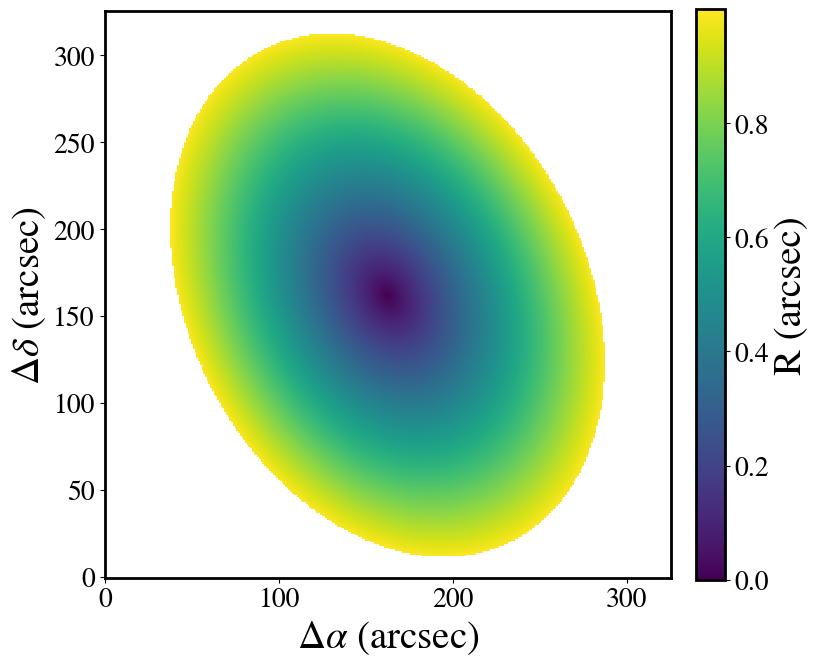

In [23]:
R_coord_map = NGC4030_map['SPX_ELLCOO'].data
R_eff_map = R_coord_map[1,:,:]
R_eff_map_mask = ma.masked_where((R_eff_map>1), R_eff_map)

plt.imshow( R_eff_map_mask,origin='lower')#,extent=[32.4, -32.6,-32.4, 32.6])
plt.ylabel(r'$\Delta \delta$ (arcsec)',fontsize=28)
plt.xlabel(r'$\Delta \alpha$ (arcsec)',fontsize=28)
clb = plt.colorbar(fraction=0.046, pad=0.04);
clb.set_label('R (arcsec)',fontsize=28,rotation = 90);

In [16]:
np.max(stellar_vel)

257.51657

In [11]:
stellar_vel.shape

(326, 326)

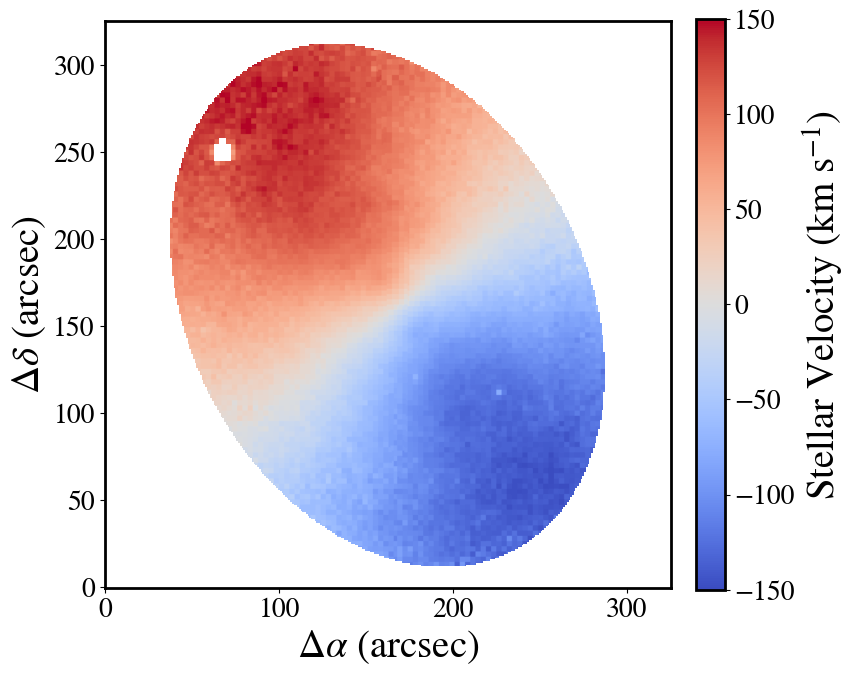

In [13]:
plt.rcParams['figure.figsize'] = (8,8)
stellar_vel_mask = ma.masked_where((R_arcsec_map>31.8)|(stellar_vel<-500), stellar_vel)

plt.imshow(stellar_vel_mask,origin='lower',cmap='coolwarm',vmin=-150,vmax=150)
#           extent=[32.4, -32.6,-32.4, 32.6])
#plt.imshow(stellar_vel_mask,origin='lower',cmap='rainbow',vmin=-150,vmax=150)
          #extent=[32.4, -32.6,-32.4, 32.6])


# x = np.arange(0, 326, 1)
# y = np.arange(0, 326, 1) # point location
# plt.contourf(x,y,stellar_vel_mask,cmap='rainbow',vmin=-150,vmax=150,)
#plt.colorbar()

# plt.xlim(35,-35)
# plt.ylim(-35,35)

plt.ylabel(r'$\Delta \delta$ (arcsec)',fontsize=28)
plt.xlabel(r'$\Delta \alpha$ (arcsec)',fontsize=28)
clb = plt.colorbar(fraction=0.046, pad=0.04);
clb.set_label('Stellar Velocity (km s$^{-1}$)',fontsize=28,rotation = 90)
# plt.savefig('/Users/erickaguirre/Desktop/paper_plots/0.6_err_corr_plots/NaI_velocities.pdf',
#             bbox_inches='tight');

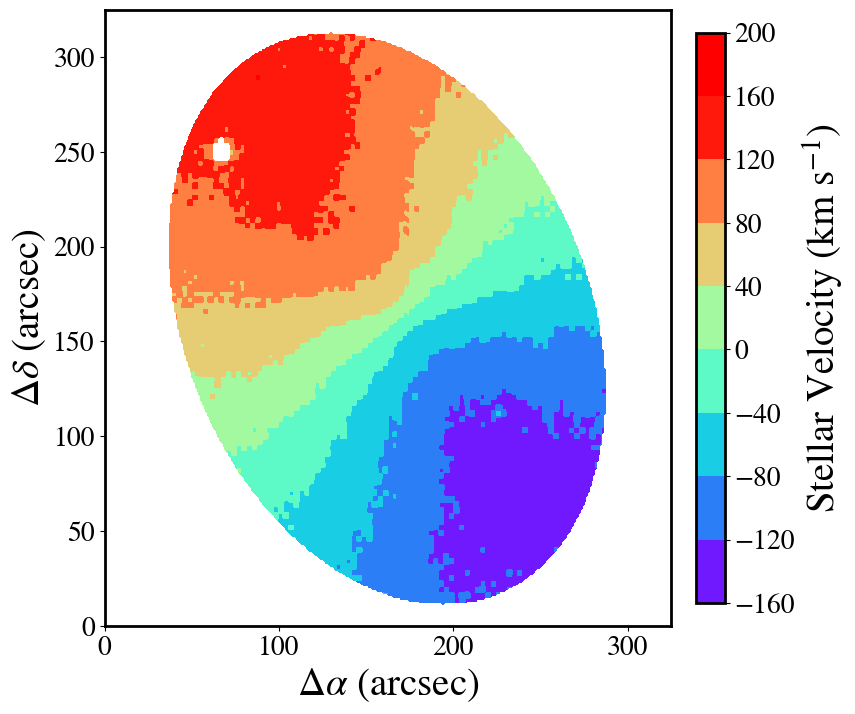

In [7]:
plt.rcParams['figure.figsize'] = (8,8)
stellar_vel_mask = ma.masked_where((R_arcsec_map>31.8)|(stellar_vel<-500), stellar_vel)
#gas_vel_mask = ma.masked_where((gas_vel_mask>-400) & (gas_vel_mask < 400),gas_vel_mask)
# plt.imshow(stellar_vel_mask,origin='lower',cmap='coolwarm',vmin=-150,vmax=150,
#           extent=[32.4, -32.6,-32.4, 32.6])
# plt.imshow(stellar_vel_mask,origin='lower',cmap='rainbow',vmin=-150,vmax=150,
#           extent=[32.4, -32.6,-32.4, 32.6])


x = np.arange(0, 326, 1)
y = np.arange(0, 326, 1) # point location


plt.contourf(x,y,stellar_vel_mask,cmap='rainbow',vmin=-150,vmax=150,)
#plt.colorbar()

# plt.xlim(35,-35)
# plt.ylim(-35,35)

plt.ylabel(r'$\Delta \delta$ (arcsec)',fontsize=28)
plt.xlabel(r'$\Delta \alpha$ (arcsec)',fontsize=28)
clb = plt.colorbar(fraction=0.046, pad=0.04);
clb.set_label('Stellar Velocity (km s$^{-1}$)',fontsize=28,rotation = 90)
# plt.savefig('/Users/erickaguirre/Desktop/paper_plots/0.6_err_corr_plots/NaI_velocities.pdf',
#             bbox_inches='tight');

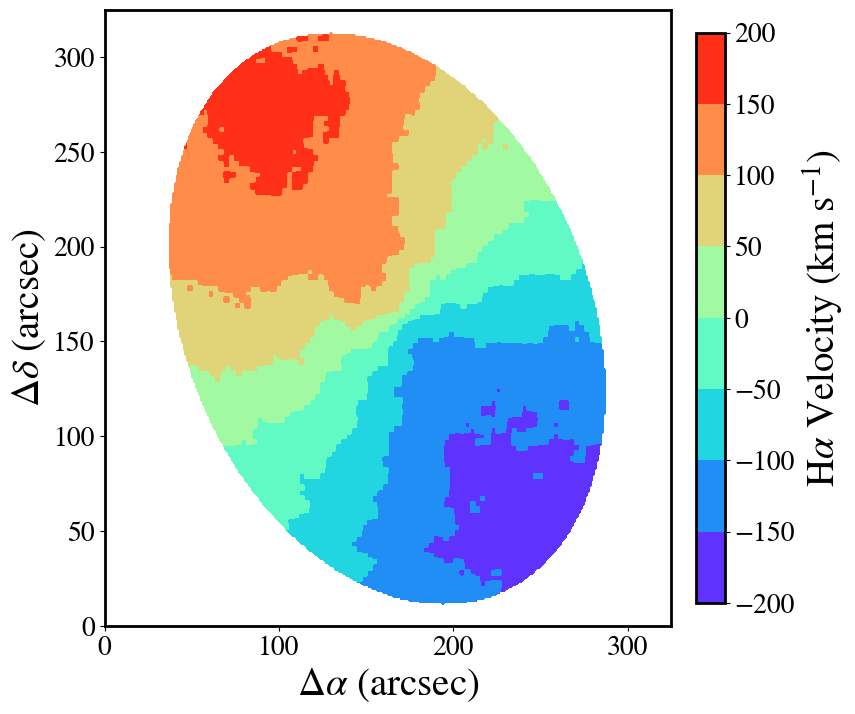

In [8]:
plt.rcParams['figure.figsize'] = (8,8)
halpha_vel_map_mask = ma.masked_where((R_arcsec_map>31.8), halpha_vel_map)
#gas_vel_mask = ma.masked_where((gas_vel_mask>-400) & (gas_vel_mask < 400),gas_vel_mask)
# plt.imshow(halpha_vel_map_mask,origin='lower',cmap='coolwarm',vmin=-150,vmax=150,
#           extent=[32.4, -32.6,-32.4, 32.6])
# plt.imshow(halpha_vel_map_mask,origin='lower',cmap='rainbow',vmin=-150,vmax=150,
#           extent=[32.4, -32.6,-32.4, 32.6])
# plt.imshow(gas_vel_mask,origin='lower',cmap='rainbow',vmin=-150,vmax=150,
#           extent=[32.4, -32.6,-32.4, 32.6])

x = np.arange(0, 326, 1)
y = np.arange(0, 326, 1) # point location
plt.contourf(x,y,halpha_vel_map_mask,cmap='rainbow')

# plt.xlim(35,-35)
# plt.ylim(-35,35)

plt.ylabel(r'$\Delta \delta$ (arcsec)',fontsize=28)
plt.xlabel(r'$\Delta \alpha$ (arcsec)',fontsize=28)
clb = plt.colorbar(fraction=0.046, pad=0.04);
clb.set_label(r'H$\alpha$ Velocity (km s$^{-1}$)',fontsize=28,rotation = 90)
# plt.savefig('/Users/erickaguirre/Desktop/paper_plots/0.6_err_corr_plots/NaI_velocities.pdf',
#             bbox_inches='tight');

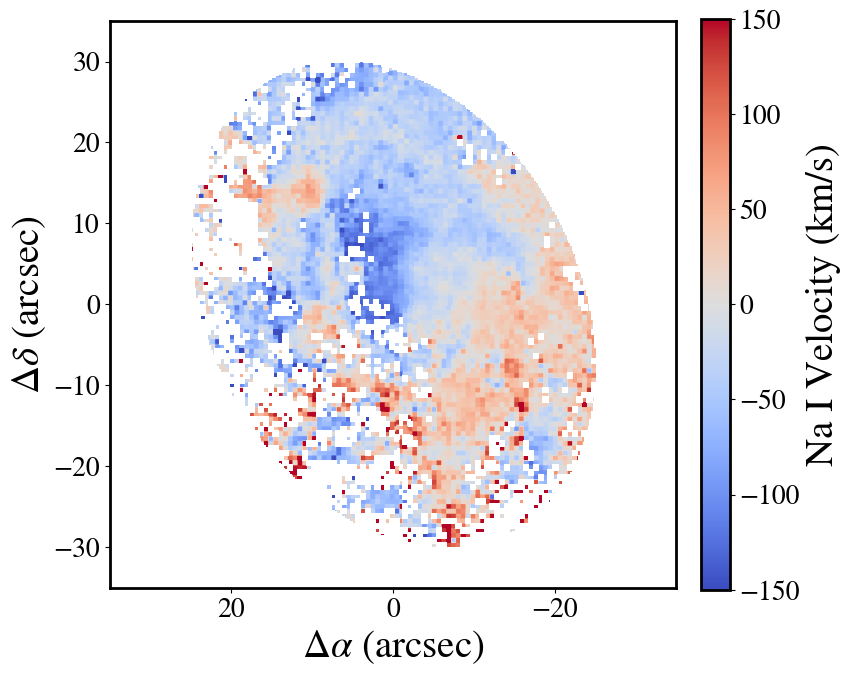

In [9]:
plt.rcParams['figure.figsize'] = (8,8)
gas_vel_mask = ma.masked_where((vel_width_map>100) | (binid_map==-1) | (R_arcsec_map>31.8) , gas_vel_map)
#gas_vel_mask = ma.masked_where((gas_vel_mask>-400) & (gas_vel_mask < 400),gas_vel_mask)
plt.imshow(gas_vel_mask,origin='lower',cmap='coolwarm',vmin=-150,vmax=150,
          extent=[32.4, -32.6,-32.4, 32.6])
# plt.imshow(gas_vel_mask,origin='lower',cmap='rainbow',vmin=-150,vmax=150,
#           extent=[32.4, -32.6,-32.4, 32.6])

plt.xlim(35,-35)
plt.ylim(-35,35)

plt.ylabel(r'$\Delta \delta$ (arcsec)',fontsize=28)
plt.xlabel(r'$\Delta \alpha$ (arcsec)',fontsize=28)
clb = plt.colorbar(fraction=0.046, pad=0.04);
clb.set_label('Na I Velocity (km/s)',fontsize=28,rotation = 90)
# plt.savefig('/Users/erickaguirre/Desktop/paper_plots/0.6_err_corr_plots/NaI_velocities.pdf',
#             bbox_inches='tight');

In [10]:
NGC4030_map.info()

Filename: /Users/erickaguirre/Desktop/DAP_outputs/output0.6_NGC4030_NOISM_err_corr/SQUARE0.6-MILESHC-MASTARHC2-NOISM/1/1/manga-1-1-MAPS-SQUARE0.6-MILESHC-MASTARHC2-NOISM.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1384   ()      
  1  SPX_SKYCOO    1 ImageHDU        44   (326, 326, 2)   float32   
  2  SPX_ELLCOO    1 ImageHDU        49   (326, 326, 4)   float32   
  3  SPX_MFLUX     1 ImageHDU        36   (326, 326)   float32   
  4  SPX_MFLUX_IVAR    1 ImageHDU        37   (326, 326)   float32   
  5  SPX_SNR       1 ImageHDU        34   (326, 326)   float32   
  6  BINID         1 ImageHDU        46   (326, 326, 5)   int32   
  7  BIN_LWSKYCOO    1 ImageHDU        44   (326, 326, 2)   float32   
  8  BIN_LWELLCOO    1 ImageHDU        49   (326, 326, 4)   float32   
  9  BIN_AREA      1 ImageHDU        35   (326, 326)   float32   
 10  BIN_FAREA     1 ImageHDU        34   (326, 326)   float32   
 11  BIN_MFLUX     1 ImageHDU  

In [11]:
def xy_coord_rotation(ax1,ax2,angle):
    ax1_rot = ax1*np.cos(np.radians(-angle))+ax2*np.sin(np.radians(-angle))
    ax2_rot = -ax1*np.sin(np.radians(-angle))+ax2*np.cos(np.radians(-angle))
    return ax1_rot, ax2_rot

def cylin_disk_coord(X1,X2,X3):
    return X1,X2,X3

def cart_disk_coord(X1,X2,X3):
    Z1 = X1*np.cos(X2)
    Z2 = X1*np.sin(X2)
    Z3 = X3
    return Z1,Z2,Z3

def img_plane_coord(Z1,Z2,Z3,Y1_cent,Y2_cent,Y3_cent,incl):
    Y1 = Z1 + Y1_cent
    Y2 = Z2*np.cos(np.radians(incl)) + Y2_cent
    Y3 = Z3
    return Y1,Y2,Y3

def img_plane_coord_rot(Y1,Y2,Y3,PA):
    # rotate coordinates to a position angle of 0 degress by rotating it initially by 90 degress
    init_angle = 90
    Y1_rot,Y2_rot = xy_coord_rotation(Y1,Y2,init_angle)
    
    # rotate coordinate system to position angle
    Y1_rot_PA, Y2_rot_PA = xy_coord_rotation(Y1_rot,Y2_rot,PA)
    Y3_rot_PA = Y3
    return Y1_rot_PA,Y2_rot_PA,Y3_rot_PA

def get_R_theta_maps(incl,PA):
    
    # create image plane array
    h, w = (1.2,1.2) # img size
    
    # define x and y axis range
    x = np.linspace(-w, w, int(1e3))
    y = np.linspace(-h, h, int(1e3))
    
    # create grid of points in both the x and y direction
    xx, yy = np.meshgrid(x,y)
    
    # radius map R and azimuthal angle (theta) without any inclination
    R_map_orig = np.sqrt(xx**2 + yy**2)
    theta_map_orig = np.arctan2(yy,xx)

    # arctan2 function only provides values from -pi to pi. Adding 2pi provides the 
    # full 360 degrees in radians
    theta_map_orig[theta_map_orig<0] = theta_map_orig[theta_map_orig<0] + 2*np.pi
    #theta_map_orig
    
        # rotate theta map to a position angle 
    #theta_map_orig_rot = 
    
    
    # assume thin cylindrical disk (z=0) (for now)
    z = np.zeros(R_map_orig.shape)
    
    # initial cylindrical coordinates
    X1, X2, X3 = cylin_disk_coord(R_map_orig,theta_map_orig,z)
    
    # convert from cylindrical to native cartesian coordinates 
    Z1,Z2,Z3 = cart_disk_coord(X1,X2,X3)
    
    # image plane center definiton
    Y1_cent,Y12_cent,Y13_cent = 0,0,0
    
    # convert from native cartesian coordinates to image plane coordinates
    Y1,Y2,Y3 = img_plane_coord(Z1,Z2,Z3,Y1_cent,Y12_cent,Y13_cent,incl)
    
    Y1_rot_PA,Y2_rot_PA,Y3_rot_PA = img_plane_coord_rot(Y1,Y2,Y3,PA)
    
    # radius and azimuthal map after coordinate transformation
    R_map = np.sqrt(Y1_rot_PA**2 + Y2_rot_PA**2)

    theta_map = np.arctan2(Y2_rot_PA,Y2_rot_PA)
    theta_map[theta_map<0] = theta_map[theta_map<0] + 2*np.pi
    
    # mask pixels using boundary condition from original radius map
    R_map_orig_mask = ma.masked_where(R_map_orig>=1, R_map_orig)
    theta_map_mask = ma.masked_where(R_map_orig>=1, theta_map_orig)
    
    return Y1_rot_PA,Y2_rot_PA,Y3_rot_PA,R_map_orig_mask,theta_map_mask

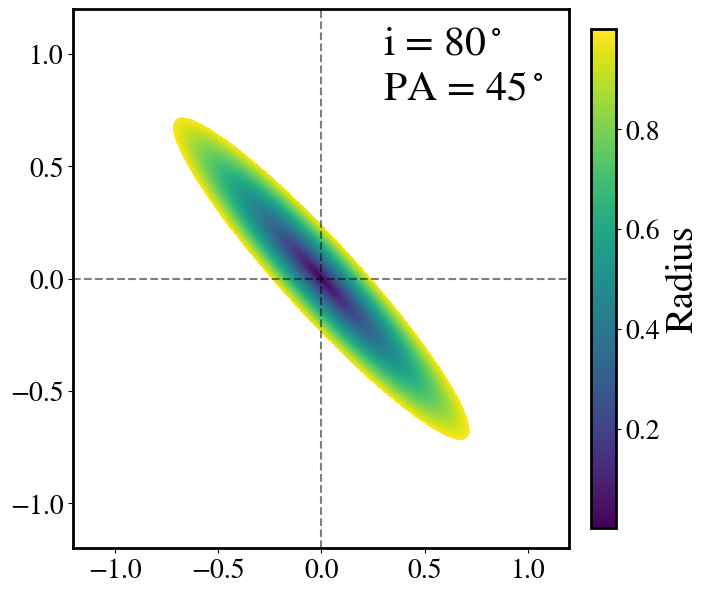

In [13]:
# inclination angle
incl = 80 # deg

# Position Angle (PA)
phi = 45 # deg

# x and y center
x0 = 0
y0 = 0

# image plane coordinate map along with masked radius and azimuthal map
Y1,Y2,Y3,R_map_orig_mask,theta_map_mask = get_R_theta_maps(incl,phi)

# constant circular velocity
V_const = 200 #km/s
# velocity for a solid rotating disk
V_circ = V_const * R_map_orig_mask

cos_theta_map = ( -(Y1-x0)*np.sin(np.radians(phi)) + (Y2-y0)*np.cos(np.radians(phi)) ) / R_map_orig_mask
V_LOS = V_circ * np.cos(theta_map_mask)* np.sin(np.radians(incl))
#V_LOS = V_circ * cos_theta_map * np.sin(np.radians(incl))

plt.rcParams['figure.figsize'] = (7,7)

fig, ax = plt.subplots()
#cs = ax.pcolormesh(Y1, Y2, V_LOS,cmap='coolwarm',vmin=-200,vmax=200)
cs = ax.pcolormesh(Y1, Y2, R_map_orig_mask,cmap='viridis')

ax.set_ylim(-1.2,1.2)
ax.set_xlim(-1.2,1.2)
ax.axvline(0,ls='--',c='k',alpha=0.5)
ax.axhline(0,ls='--',c='k',alpha=0.5)

circ_txt = r'$^\circ$'
ax.annotate(text=('i = {}'.format(incl)) + circ_txt, xy=(0.3,1),fontsize=30)
ax.annotate(text=('PA = {}'.format(phi)) + circ_txt, xy=(0.3,.8),fontsize=30)
clb = fig.colorbar(cs,fraction=0.046, pad=0.04)
clb.set_label(r'Radius',fontsize=28,rotation = 90)

In [15]:
R_ranges = np.arange(0,1+.2,.2)

R_radii = []
VLOS_radii = []
for i in range(len(R_ranges)-1):
    R_rad_mask = ma.masked_where((R_map_orig_mask.data<R_ranges[i]) | 
                                 (R_map_orig_mask.data>R_ranges[i+1]),R_map_orig_mask.data)
    V_LOS_rad_mask = ma.masked_where((R_map_orig_mask.data<R_ranges[i]) | 
                                 (R_map_orig_mask.data>R_ranges[i+1]),V_LOS.data)
    R_radii.append(R_rad_mask)
    VLOS_radii.append(V_LOS_rad_mask)

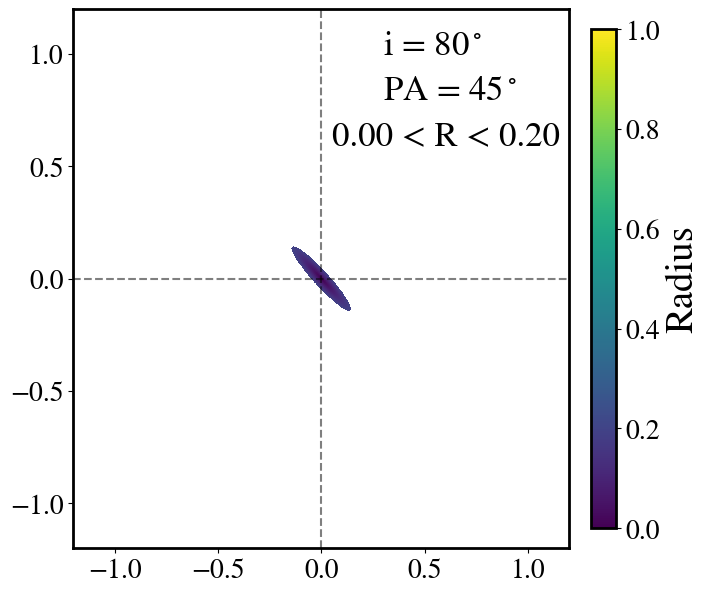

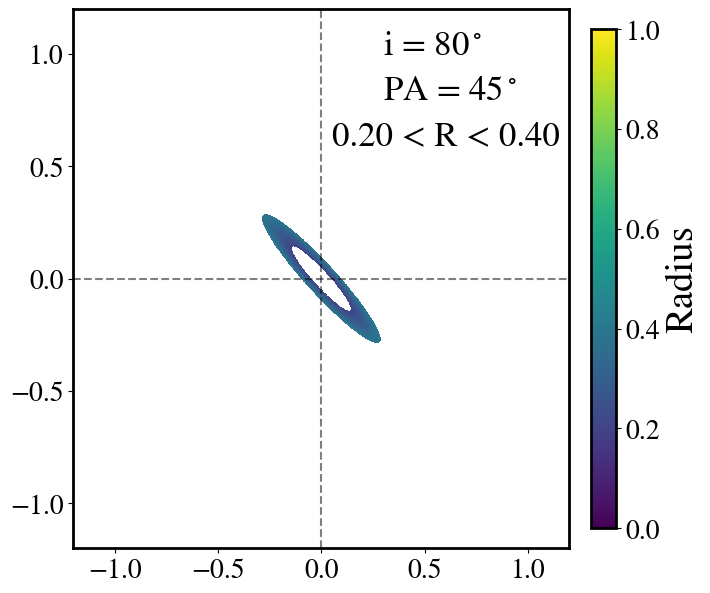

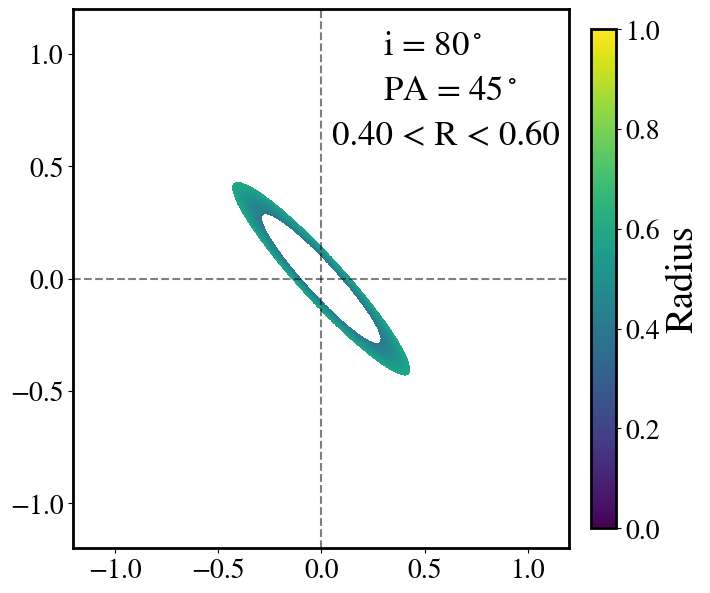

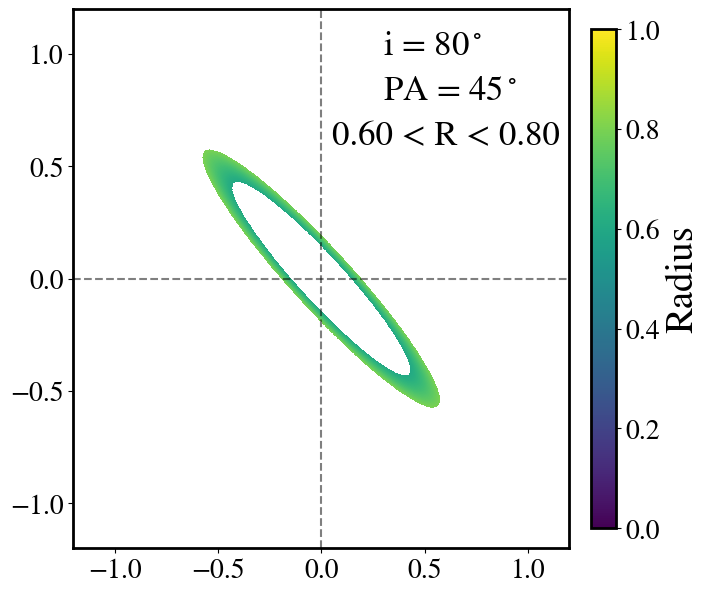

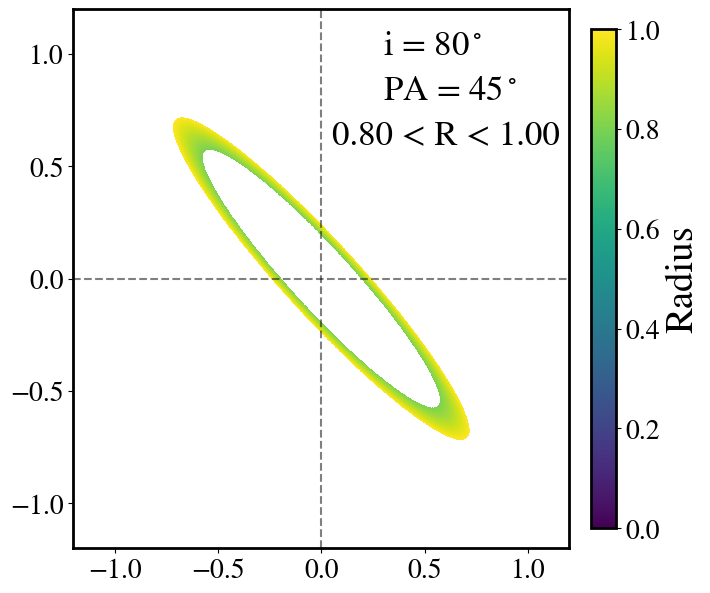

In [90]:
plt.rcParams['figure.figsize'] = (7,7)

for i in range(len(R_radii)):
    
    fig, ax = plt.subplots()
    #cs = ax.pcolormesh(Y1, Y2, V_LOS,cmap='coolwarm',vmin=-200,vmax=200)
    cs = ax.pcolormesh(Y1, Y2, R_radii[i],cmap='viridis',vmin=0,vmax=1)

    ax.set_ylim(-1.2,1.2)
    ax.set_xlim(-1.2,1.2)
    ax.axvline(0,ls='--',c='k',alpha=0.5)
    ax.axhline(0,ls='--',c='k',alpha=0.5)

    circ_txt = r'$^\circ$'
    ax.annotate(text=('i = {}'.format(incl)) + circ_txt, xy=(0.3,1),fontsize=25)
    ax.annotate(text=('PA = {}'.format(phi)) + circ_txt, xy=(0.3,.8),fontsize=25)
    ax.annotate(text=('{:.2f} < R < {:.2f} '.format(R_ranges[i],R_ranges[i+1])), xy=(0.05,.6),fontsize=25)
    clb = fig.colorbar(cs,fraction=0.046, pad=0.04)
    clb.set_label(r'Radius',fontsize=28,rotation = 90)



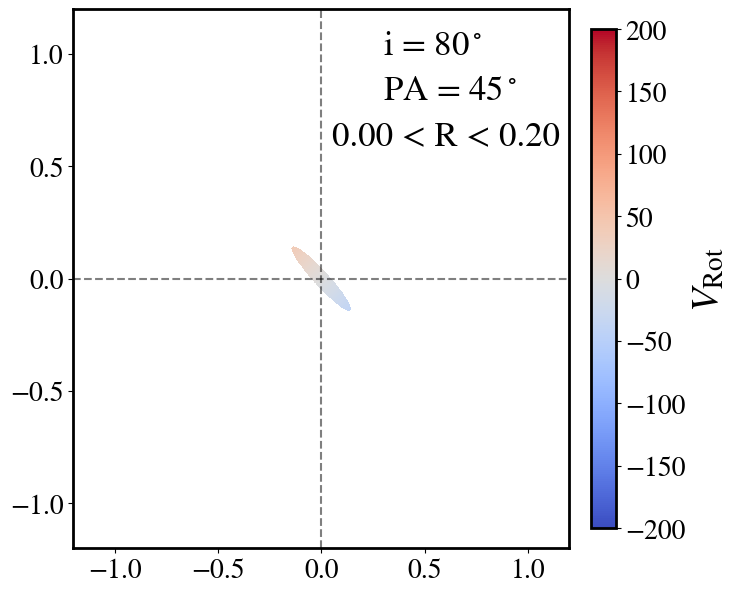

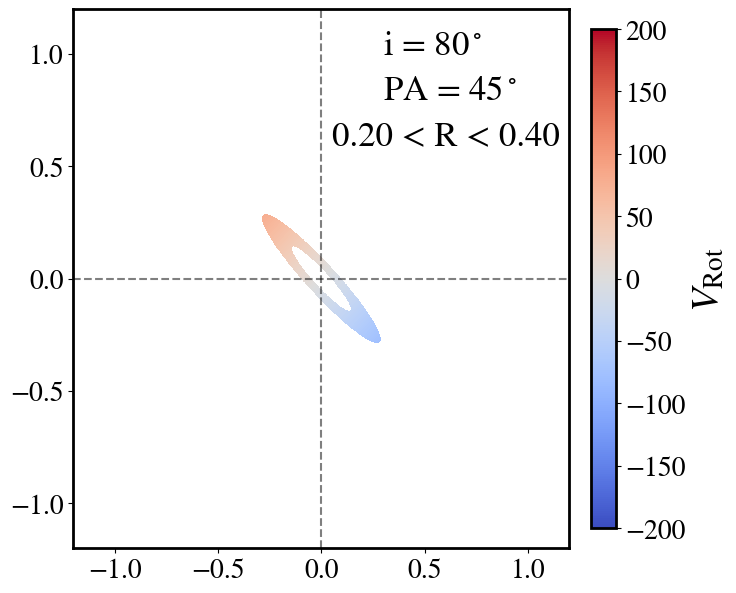

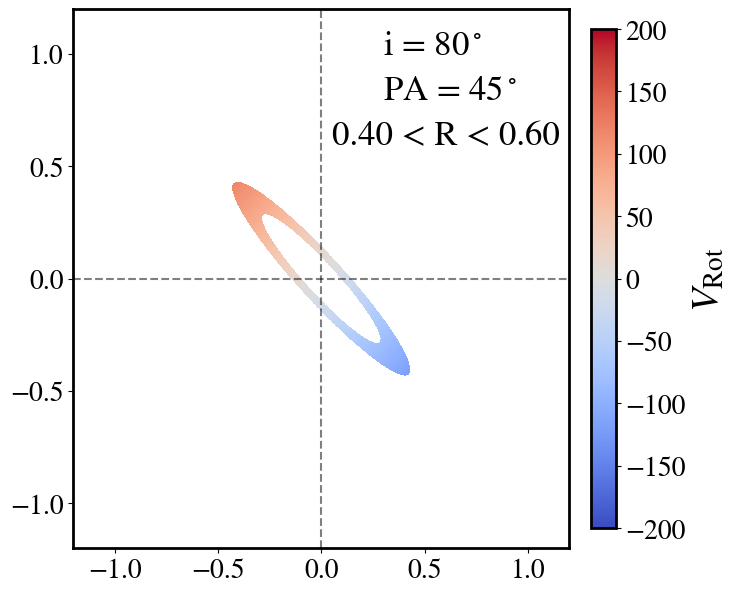

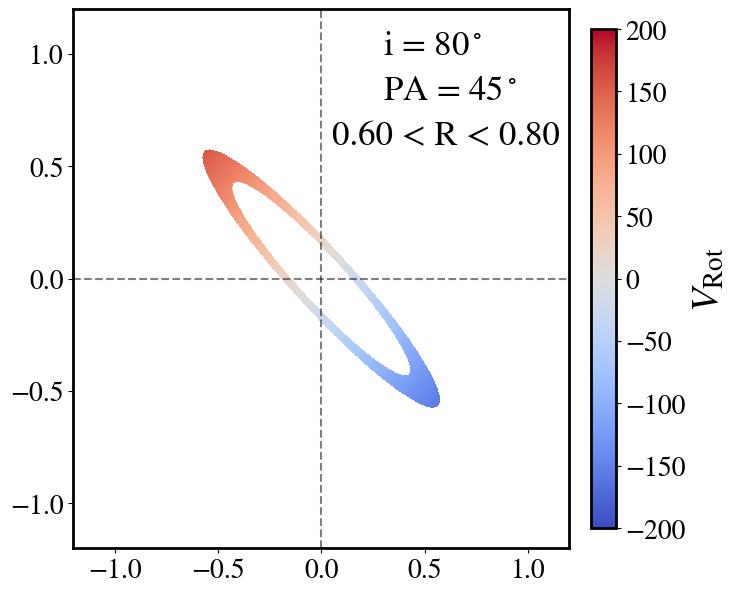

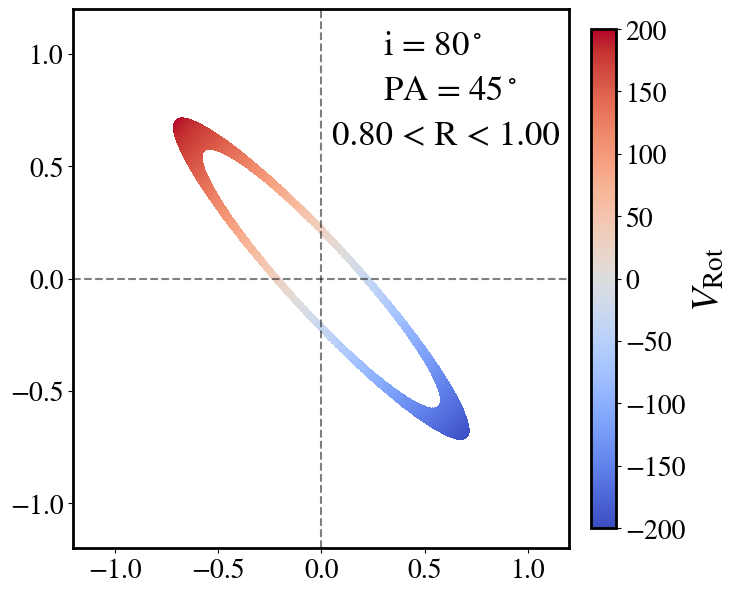

In [18]:
for i in range(len(R_radii)):
    
    fig, ax = plt.subplots()
    #cs = ax.pcolormesh(Y1, Y2, V_LOS,cmap='coolwarm',vmin=-200,vmax=200)
    cs = ax.pcolormesh(Y1, Y2, VLOS_radii[i],cmap='coolwarm',vmin=-200,vmax=200)

    ax.set_ylim(-1.2,1.2)
    ax.set_xlim(-1.2,1.2)
    ax.axvline(0,ls='--',c='k',alpha=0.5)
    ax.axhline(0,ls='--',c='k',alpha=0.5)

    circ_txt = r'$^\circ$'
    ax.annotate(text=('i = {}'.format(incl)) + circ_txt, xy=(0.3,1),fontsize=25)
    ax.annotate(text=('PA = {}'.format(phi)) + circ_txt, xy=(0.3,.8),fontsize=25)
    ax.annotate(text=('{:.2f} < R < {:.2f} '.format(R_ranges[i],R_ranges[i+1])), xy=(0.05,.6),fontsize=25)
    clb = fig.colorbar(cs,fraction=0.046, pad=0.04)
    clb.set_label(r'$V_{\mathrm{Rot}}$',fontsize=28,rotation = 90)

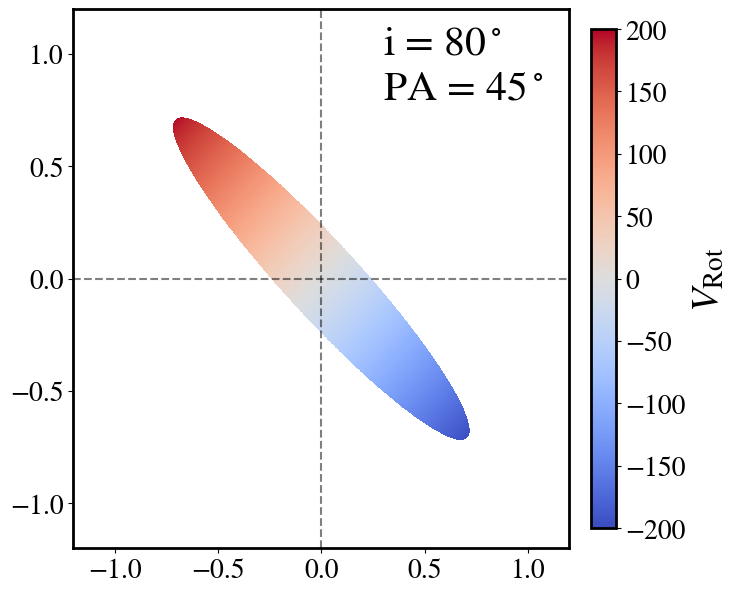

In [15]:
plt.rcParams['figure.figsize'] = (7,7)

fig, ax = plt.subplots()
cs = ax.pcolormesh(Y1, Y2, V_LOS,cmap='coolwarm',vmin=-200,vmax=200)
#cs = ax.pcolormesh(Y1, Y2, R_map_orig_mask,cmap='viridis')

ax.set_ylim(-1.2,1.2)
ax.set_xlim(-1.2,1.2)
ax.axvline(0,ls='--',c='k',alpha=0.5)
ax.axhline(0,ls='--',c='k',alpha=0.5)

circ_txt = r'$^\circ$'
ax.annotate(text=('i = {}'.format(incl)) + circ_txt, xy=(0.3,1),fontsize=30)
ax.annotate(text=('PA = {}'.format(phi)) + circ_txt, xy=(0.3,.8),fontsize=30)
clb = fig.colorbar(cs,fraction=0.046, pad=0.04)
clb.set_label(r'$V_{\mathrm{Rot}}$',fontsize=28,rotation = 90)